In [1]:
%matplotlib inline

import numpy as np
from numpy import linalg as nla
import scipy as sp
from scipy import linalg as sla
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import SHFunctions as shf
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
np.set_printoptions(linewidth = 200)

In [2]:
def NewtonSchulz(p, A, Q, X0 = np.NAN, maxiter = 100, tol = np.NAN):
    if np.sum(np.isnan(X0)) > 0: # X0가 주어지지 않았을 때 m by m zero 행렬 처리
        X0 = np.eye(A.shape[0])
    
    if (p <= 0) or (not isinstance(p, int)): # p가 positive integer가 아닐 때 예외처리
        raise ValueError('p가 양의 정수가 아닙니다.')
        
    if A.shape[0] != A.shape[1]: # A가 square matrix가 아닐 때 예외처리
        raise ValueError('A가 정방행렬이 아닙니다.')
        
    if Q.shape[0] != Q.shape[1]: # Q가 square matrix가 아닐 때 예외처리
        raise ValueError('Q가 정방행렬이 아닙니다.')
        
    if (Q.shape[0] != A.shape[0]) or (A.shape[1] != Q.shape[1]): # A와 Q가 같은 크기 아닐 때 예외처리
        raise ValueError('A, Q가 같은 크기가 아닙니다.')
        
    m = A.shape[1] # m 초기화
    
    if np.isnan(tol): # tol이 주어지지 않았을 때 초기화
        tol = m * 1e-15
        
    Xs = [X0] # Xs는 X들을 담은 리스트로 초기화
    errs = [] # err 리스트 초기화
    S = np.zeros((A.shape[0],A.shape[1]))
    
    iter = 0
    err = 1e10 # error 초기화
    
    # Newton Iteration 시작
    t = time() # 시간체크
    while (err > tol) and (iter < maxiter):
        X0 = (1/p)*((p-1)*X0 + (Q - A.conj().transpose() @ X0 @ A)@nla.inv(nla.matrix_power(X0,p-1))) # Newton Sequence 적용
        err = nla.norm(nla.matrix_power(X0, p) - (Q - (A.conj()).transpose() @ X0 @ A), 'fro') # err 계산

        Xs.append(X0) # X_i 저장
        errs.append(err) # err 저장
        
        iter += 1
    
    calcultime = time() - t
    S = Xs[-1] # Solution
    
    # Vectorize of S - X_{i}와 X_{i+1} - X_{i} : cos 계산
    vSmX = []
    vXmX = []
    for i in range(len(Xs)-1):
        vSmX.append(np.reshape(S - Xs[i], S.shape[0]*S.shape[1], order='F'))
        vXmX.append(np.reshape(Xs[i+1] - Xs[i], S.shape[0]*S.shape[1], order='F'))
    cSX = []
    cXX = []
    for i in range(len(vSmX)-1):
        x1, y1 = vSmX[i+1], vSmX[i]
        x2, y2 = vXmX[i+1], vXmX[i]
        c1 = np.dot(x1,y1) / (nla.norm(x1,2)*nla.norm(y1,2))
        c2 = np.dot(x2,y2) / (nla.norm(x2,2)*nla.norm(y2,2))
        cSX.append(c1)
        cXX.append(c2)
    return {'sol':S, 'Xs':Xs, 'errs':errs, 'time':calcultime, 'SmX':vSmX, 'XmX':vXmX, 'csSmX':cSX, 'csXmX':cXX}

def Newton_pth(p, A, X0 = np.NAN, maxiter = 100, tol = np.NAN):
    if np.sum(np.isnan(X0)) > 0: # X0가 주어지지 않았을 때 m by m zero 행렬 처리
#         X0 = np.eye(A.shape[0])
        X0 = A
    
    if (p <= 0) or (not isinstance(p, int)): # p가 positive integer가 아닐 때 예외처리
        raise ValueError('p가 양의 정수가 아닙니다.')
        
    if A.shape[0] != A.shape[1]: # A가 square matrix가 아닐 때 예외처리
        raise ValueError('A가 정방행렬이 아닙니다.')
        
    m = A.shape[1] # m 초기화
    
    if np.isnan(tol): # tol이 주어지지 않았을 때 초기화
        tol = m * p * 1e-15
        
    Xs = [X0] # Xs는 X들을 담은 리스트로 초기화
    errs = [] # err 리스트 초기화
    S = np.zeros((A.shape[0],A.shape[1]))
    
    iter = 0
    err = 1e10 # error 초기화
    
    # Newton Iteration 시작
    t = time() # 시간체크
    while (err > tol) and (iter < maxiter):
        X0 = (1/p)*((p-1)*X0 + A@nla.inv(nla.matrix_power(X0,p-1))) # Newton Sequence 적용
        err = nla.norm(nla.matrix_power(X0, p) - A, 'fro') # err 계산

        Xs.append(X0) # X_i 저장
        errs.append(err) # err 저장
        
        iter += 1
    
    calcultime = time() - t
    S = Xs[-1] # Solution
    
    # Vectorize of S - X_{i}와 X_{i+1} - X_{i} : cos 계산
    vSmX = []
    vXmX = []
    for i in range(len(Xs)-1):
        vSmX.append(np.reshape(S - Xs[i], S.shape[0]*S.shape[1], order='F'))
        vXmX.append(np.reshape(Xs[i+1] - Xs[i], S.shape[0]*S.shape[1], order='F'))
    cSX = []
    cXX = []
    for i in range(len(vSmX)-1):
        x1, y1 = vSmX[i+1], vSmX[i]
        x2, y2 = vXmX[i+1], vXmX[i]
        c1 = np.dot(x1,y1) / (nla.norm(x1,2)*nla.norm(y1,2))
        c2 = np.dot(x2,y2) / (nla.norm(x2,2)*nla.norm(y2,2))
        cSX.append(c1)
        cXX.append(c2)
    return {'sol':S, 'Xs':Xs, 'errs':errs, 'time':calcultime, 'SmX':vSmX, 'XmX':vXmX, 'csSmX':cSX, 'csXmX':cXX}



array([[ 1.14258978e+00, -2.80268853e-03, -4.40441099e-03, -1.13784394e-02, -8.68164100e-03, -3.26516297e-03],
       [-7.25839555e-03,  1.13353855e+00, -6.49612475e-03, -1.41405460e-02, -1.64352711e-02, -1.67586889e-02],
       [-6.78685576e-03, -1.07160032e-02,  1.14243826e+00, -7.41379421e-03, -1.00264365e-02, -7.81329061e-03],
       [-1.27675909e-02, -1.44963887e-02, -1.96990775e-03,  1.13947242e+00, -1.34335738e-02, -4.17411921e-03],
       [-4.78390398e-03, -1.69324602e-02, -9.10915361e-04, -1.31250221e-02,  1.14485452e+00, -9.78139091e-03],
       [-1.04494452e-02, -7.83032901e-03, -3.45322722e-03, -6.29764096e-03, -1.33261072e-02,  1.14107540e+00]])

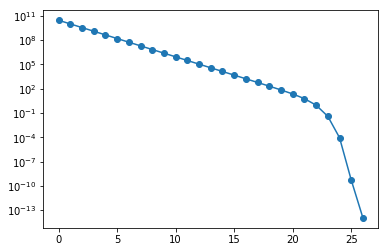

In [8]:
p = 13
m = 6
A = m*np.eye(m) - np.random.rand(m,m)
S = Newton_pth(p, A)
ax = plt.subplot(111)
ax.semilogy(S['errs'],'-o')
S['sol']